# Settings

## Libraries

In [ ]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics as mtc

from xgboost import XGBRegressor

## Functions

In [ ]:
def is_outlier(serie, factor=1.5):
  import numpy as np

  Q1, Q3 = np.quantile(serie, [0.25, 0.75])
  IQR = Q3 - Q1

  lower_fence = Q1 - factor * IQR
  upper_fence = Q3 + factor * IQR

  return (serie < lower_fence) | (serie > upper_fence)

## Load Data

In [ ]:
df = pd.read_csv('insurance.csv')

# Data Understanding & Preparation

In [ ]:
# Analisando uma amostra para entender a natureza dos dados
df.head()

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.560,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


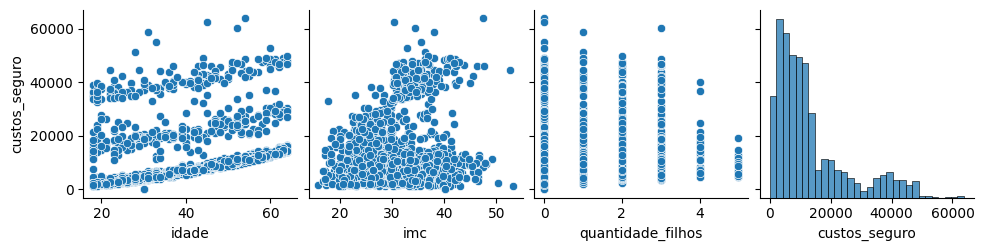

In [ ]:
sns.pairplot(df, y_vars=['custos_seguro'])

## Preparações gerais

In [ ]:
# Buscando popr mais informações, sendo as principais: presença de nulos e os tipos de dados das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341 entries, 0 to 1340
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idade              1341 non-null   int64  
 1   sexo               1338 non-null   object 
 2   imc                1341 non-null   float64
 3   quantidade_filhos  1341 non-null   int64  
 4   fumante            1341 non-null   object 
 5   regiao             1341 non-null   object 
 6   custos_seguro      1341 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.5+ KB


In [ ]:
# percebendo a presença de nulos, filtro o DataFrame para visualizar as linhas
df[df.isna().any(axis=1)]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
1259,30,NaN,40.09,0,no,northeast,0.0
1285,30,NaN,40.09,0,no,northeast,0.0
1331,30,NaN,40.09,0,no,northeast,0.0


In [ ]:
# Percebendo que as linhas estão duplicadas e não fornecem informações relevantes, irei retira-las da análise
df.dropna(inplace=True)

In [ ]:
# Verificando duplicatas
df[df.duplicated(keep=False)]

,idade,sexo,imc,quantidade_filhos,fumante,regiao,custos_seguro
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [ ]:
# Como a duplicata é uma cópia completa da primeira ocorrência e levando em consideração que valores identicos de seguro, IMC, Localidade, sexo e idade são impossíveis
df.drop_duplicates(inplace=True)

## Preparação de features numéricas

In [ ]:
# Analisando métricas estatisticas do DataFrame
df.describe()

,idade,imc,quantidade_filhos,custos_seguro
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663871,1.095737,13279.121487
std,14.044333,6.100648,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


### Analise e correção de Outliers

In [ ]:
numeric_cols = df.select_dtypes('number').columns

<Axes: >

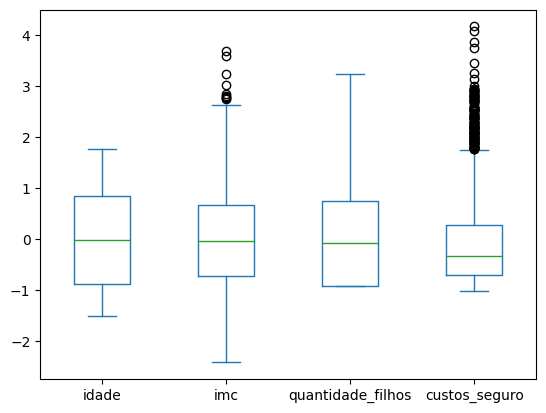

In [ ]:
# Plotando boxplots para visualizar a distribuição dos dados
df[numeric_cols].apply(scale).plot.box()

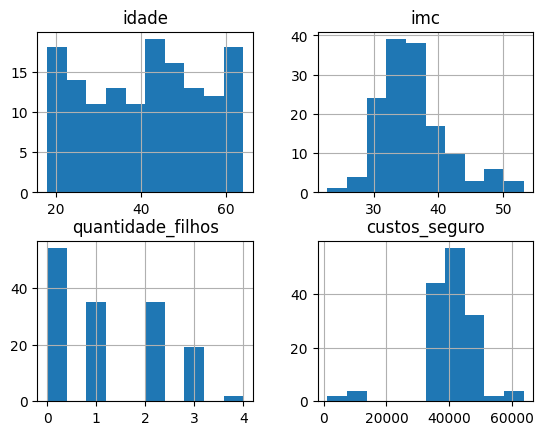

In [ ]:
# Percebendo a presença de outliers, usando a função 'is outlier' filtro o dataframe para obter essas observações dentro de um gráfico do tipo histograma
df[df[numeric_cols].apply(is_outlier).any(axis=1)].hist();

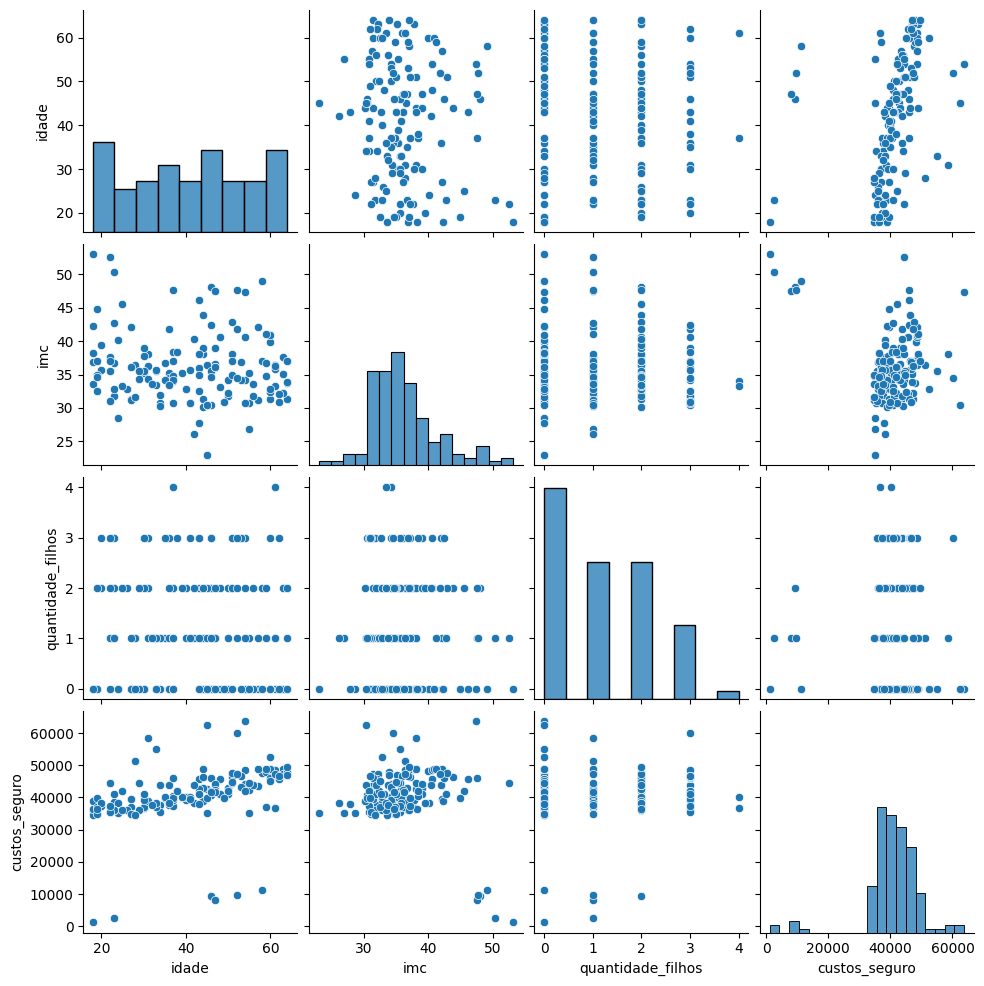

In [ ]:
# visualizando as observações com outlier em scatterplots
sns.pairplot(df[df[numeric_cols].apply(is_outlier).any(axis=1)])

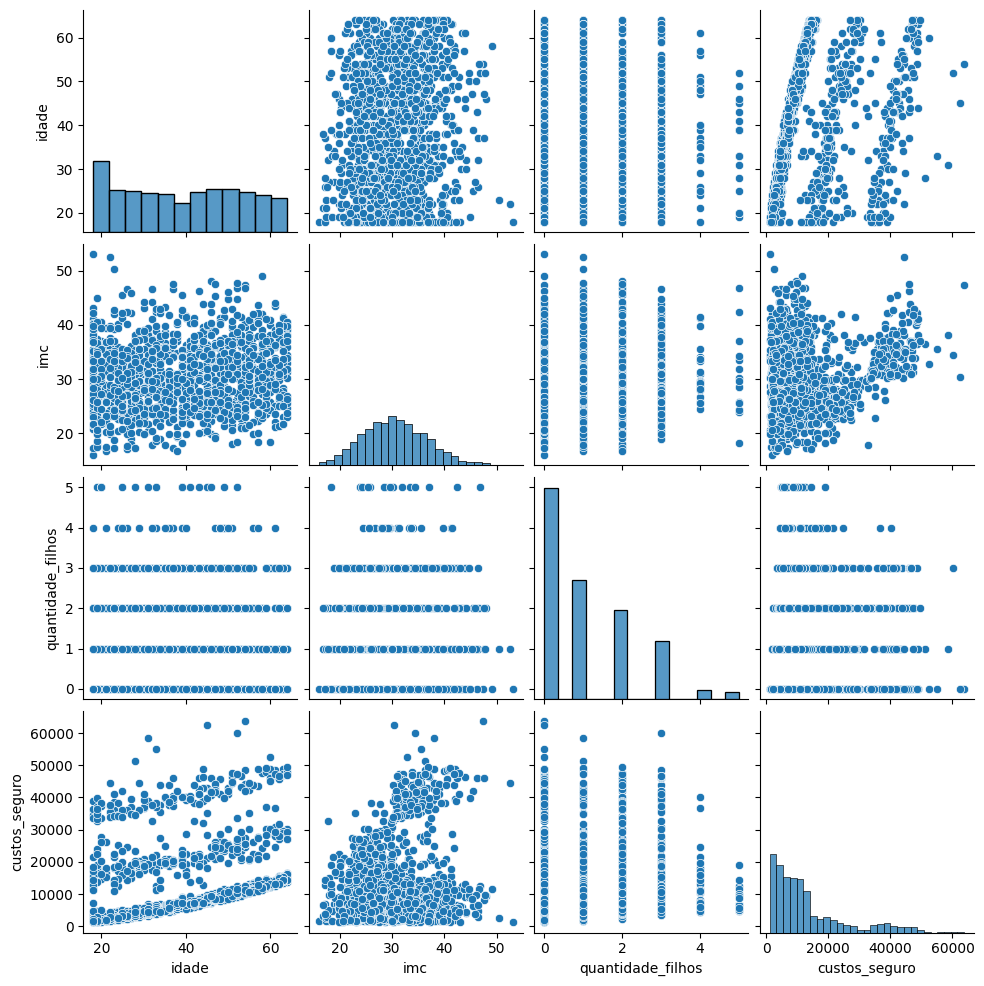

In [ ]:
# Visualizando todas as observações em scatter para entender o quão longe os outliers etão da maioria
sns.pairplot(df)

<Axes: >

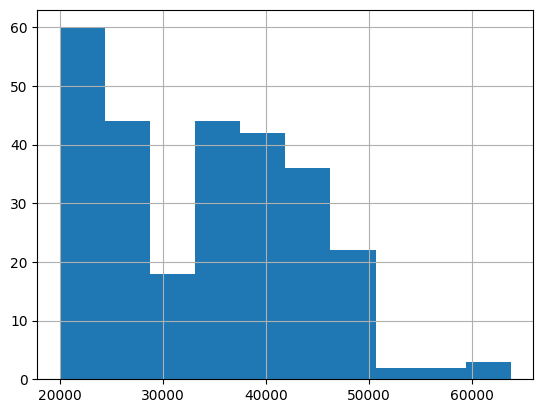

In [ ]:
# Verificando os dados maiores que R$ 20.000
df.loc[df['custos_seguro'] > 20000, 'custos_seguro'].hist()

**Analisando as estatisticas descritivas dos dados maiores e menores que 40.000 a partir de 20.000**

In [ ]:
df[(df['custos_seguro'] < 40000) & (df['custos_seguro'] > 20000)].describe()

,idade,imc,quantidade_filhos,custos_seguro
count,194.000000,194.000000,194.000000,194.000000
mean,39.896907,30.236469,1.067010,29222.343103
std,14.191134,5.086013,1.115433,6529.148422
min,18.000000,17.765000,0.000000,20009.633650
25%,27.000000,26.402500,0.000000,23293.333050
50%,41.500000,30.010000,1.000000,27766.506925
75%,52.000000,33.982500,2.000000,35593.086350
max,64.000000,44.880000,4.000000,39983.425950


In [ ]:
df[df['custos_seguro'] > 40000].describe()

,idade,imc,quantidade_filhos,custos_seguro
count,79.000000,79.000000,79.000000,79.000000
mean,48.746835,36.721203,1.303797,45681.017475
std,10.712404,4.529132,1.136283,4798.610322
min,22.000000,30.210000,0.000000,40003.332250
25%,43.000000,33.715000,0.000000,42167.826750
50%,50.000000,36.080000,1.000000,44585.455870
75%,57.500000,38.945000,2.000000,47433.387000
max,64.000000,52.580000,4.000000,63770.428010


**Analisando os dados chego a conclusão de que o custo do seguro se concentra em Três faixas principais sendo a mais alta até 50.000, o que me fez chegar a conclusão da exclusão das observações com valores de custo maiores que R$ 50.000**

In [ ]:
df = df[df['custos_seguro'] <= 50000]

### Padronização da escala

In [ ]:
df.loc[:, numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])

<ipython-input-25-b19390c35a69>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.02173913 0.         0.2173913  ... 0.         0.06521739 0.93478261]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])
<ipython-input-25-b19390c35a69>:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.  0.2 0.6 ... 0.  0.  0. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_cols] = MinMaxScaler().fit_transform(df[numeric_cols])


## Preparação de features categóricas

In [ ]:
# Criando Variaveis 'Dummies' usando a técnica OneHotEncoding
df = pd.get_dummies(df)

# Modelling

## Análise de correlação e importancia

In [ ]:
# Analisando a correlação linear de todas as variáveis
df.corr()

,idade,imc,quantidade_filhos,custos_seguro,sexo_female,sexo_male,fumante_no,fumante_yes,regiao_northeast,regiao_northwest,regiao_southeast,regiao_southwest
idade,1.000000,0.108350,0.042260,0.303853,0.021379,-0.021379,0.028943,-0.028943,0.003764,0.001544,-0.013911,0.009132
imc,0.108350,1.000000,0.014968,0.187067,-0.049005,0.049005,0.006197,-0.006197,-0.138365,-0.136828,0.270516,-0.005734
quantidade_filhos,0.042260,0.014968,1.000000,0.076377,-0.016731,0.016731,-0.010746,0.010746,-0.024100,0.024060,-0.021555,0.022438
custos_seguro,0.303853,0.187067,0.076377,1.000000,-0.058287,0.058287,-0.785604,0.785604,0.010712,-0.042277,0.074376,-0.045679
sexo_female,0.021379,-0.049005,-0.016731,-0.058287,1.000000,-1.000000,0.076195,-0.076195,-0.000150,0.012121,-0.018133,0.006864
sexo_male,-0.021379,0.049005,0.016731,0.058287,-1.000000,1.000000,-0.076195,0.076195,0.000150,-0.012121,0.018133,-0.006864
fumante_no,0.028943,0.006197,-0.010746,-0.785604,0.076195,-0.076195,1.000000,-1.000000,-0.005065,0.037870,-0.068860,0.038708
fumante_yes,-0.028943,-0.006197,0.010746,0.785604,-0.076195,0.076195,-1.000000,1.000000,0.005065,-0.037870,0.068860,-0.038708
regiao_northeast,0.003764,-0.138365,-0.024100,0.010712,-0.000150,0.000150,-0.005065,0.005065,1.000000,-0.320099,-0.346340,-0.320755
regiao_northwest,0.001544,-0.136828,0.024060,-0.042277,0.012121,-0.012121,0.037870,-0.037870,-0.320099,1.000000,-0.345632,-0.320099


<Axes: >

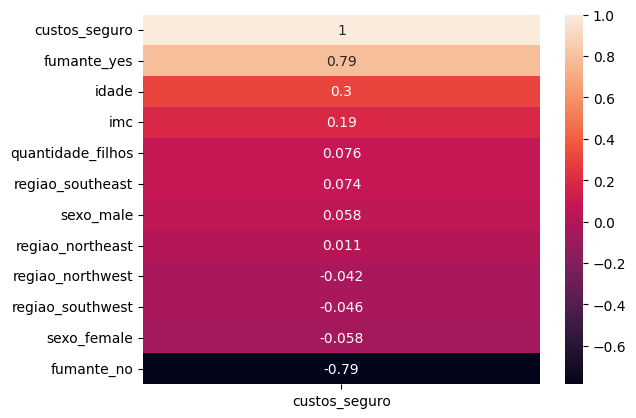

In [ ]:
# Analisando visualmente a correlação linear das variaveis com 'custos_seguro' o nosso target.
sns.heatmap(df.corr()[['custos_seguro']].sort_values(by='custos_seguro', ascending=False), annot=True)

In [ ]:
# Criando um modelo OLS do statsmodels.formula para visualizar o relatório e conferir os valores P>|z|
formula = 'custos_seguro~fumante_yes+fumante_no+idade+imc+quantidade_filhos+regiao_southeast+regiao_southwest+regiao_northwest+regiao_northeast+sexo_male+sexo_female'

print(smf.ols(formula=formula, data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          custos_seguro   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     502.4
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:12:29   Log-Likelihood:                 932.30
No. Observations:                1330   AIC:                            -1847.
Df Residuals:                    1321   BIC:                            -1800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
# Retirando do modelo variaveis sem importância para o modelo
formula = 'custos_seguro~fumante_yes+fumante_no+idade+imc+quantidade_filhos+sexo_male+sexo_female-1'

print(smf.ols(formula=formula, data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:          custos_seguro   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     800.8
Date:                Tue, 22 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:12:29   Log-Likelihood:                 929.26
No. Observations:                1330   AIC:                            -1847.
Df Residuals:                    1324   BIC:                            -1815.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
fumante_yes[False]     -0.0872    

## Organizando massas para modelagem

In [ ]:
# Rertirando variáveis sem importância e com pouca correlação linear.
df.drop(['regiao_northeast', 'regiao_northwest', 'regiao_southeast', 'regiao_southwest'], axis=1, inplace=True)

In [ ]:
# Dividindo as variaveis independentes e a dependente, assim como as massas de treino e teste.
x = df.drop('custos_seguro', axis=1)

y = df['custos_seguro']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Criando e Treinando modelos

### LinearRegression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

### DecisionTree

In [ ]:
DT_reg = DecisionTreeRegressor()
DT_reg.fit(x_train, y_train)

DecisionTreeRegressor()

### RandomForest

In [ ]:
RF_reg = RandomForestRegressor()
RF_reg.fit(x_train, y_train)

RandomForestRegressor()

### GradientBoosting

In [ ]:
GBR_reg = GradientBoostingRegressor()
GBR_reg.fit(x_train, y_train)

GradientBoostingRegressor()

### Adaboost

In [ ]:
Ada_reg = AdaBoostRegressor()
Ada_reg.fit(x_train, y_train)

AdaBoostRegressor()

### XGB

In [ ]:
XGB = XGBRegressor()
XGB.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Criando predições e avaliando modelos

### LinearRegression

In [ ]:
y_pred = linear_model.predict(x_test)

print(f'R²: {linear_model.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.714313175944117
MAE: 0.0869480662096161
MSE: 0.01627895469852718
RMSE: 0.1275890069658322


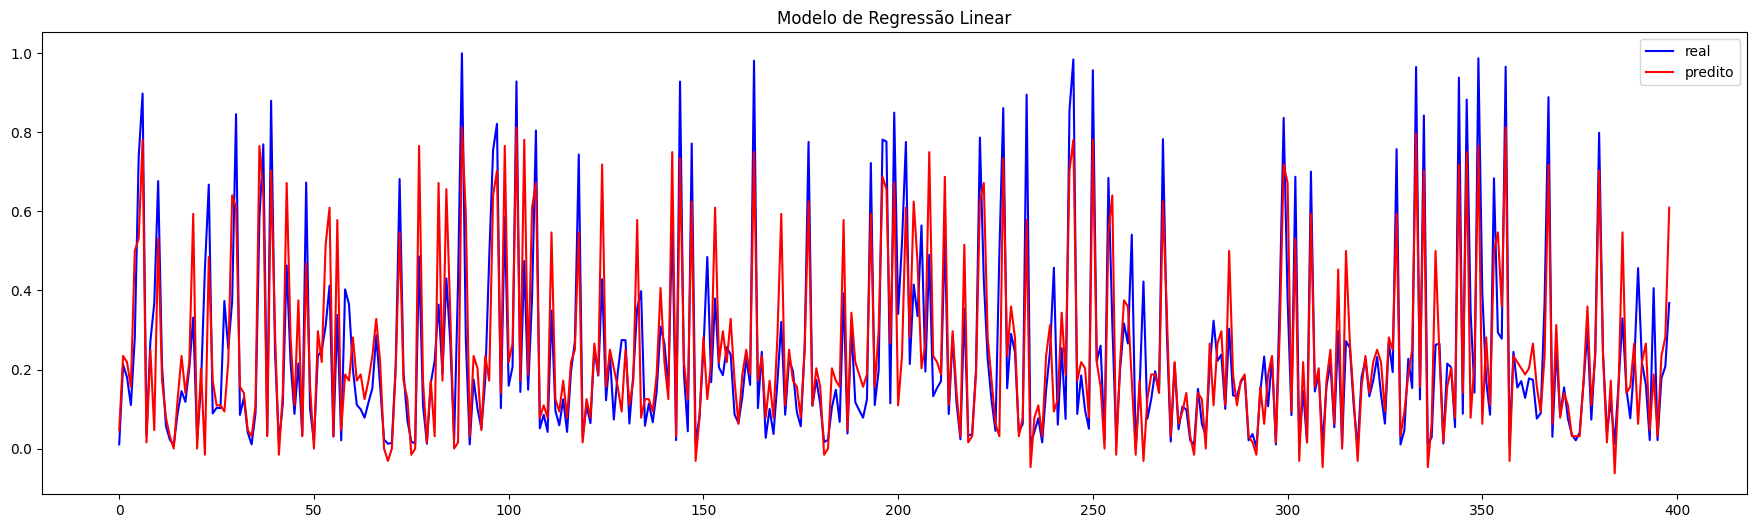

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo de Regressão Linear')
plt.legend();

### DecisionTree

In [ ]:
y_pred = DT_reg.predict(x_test)

print(f'R²: {DT_reg.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.9993845726612883
MAE: 0.05882521365410711
MSE: 0.016157675350326767
RMSE: 0.12711284494623967


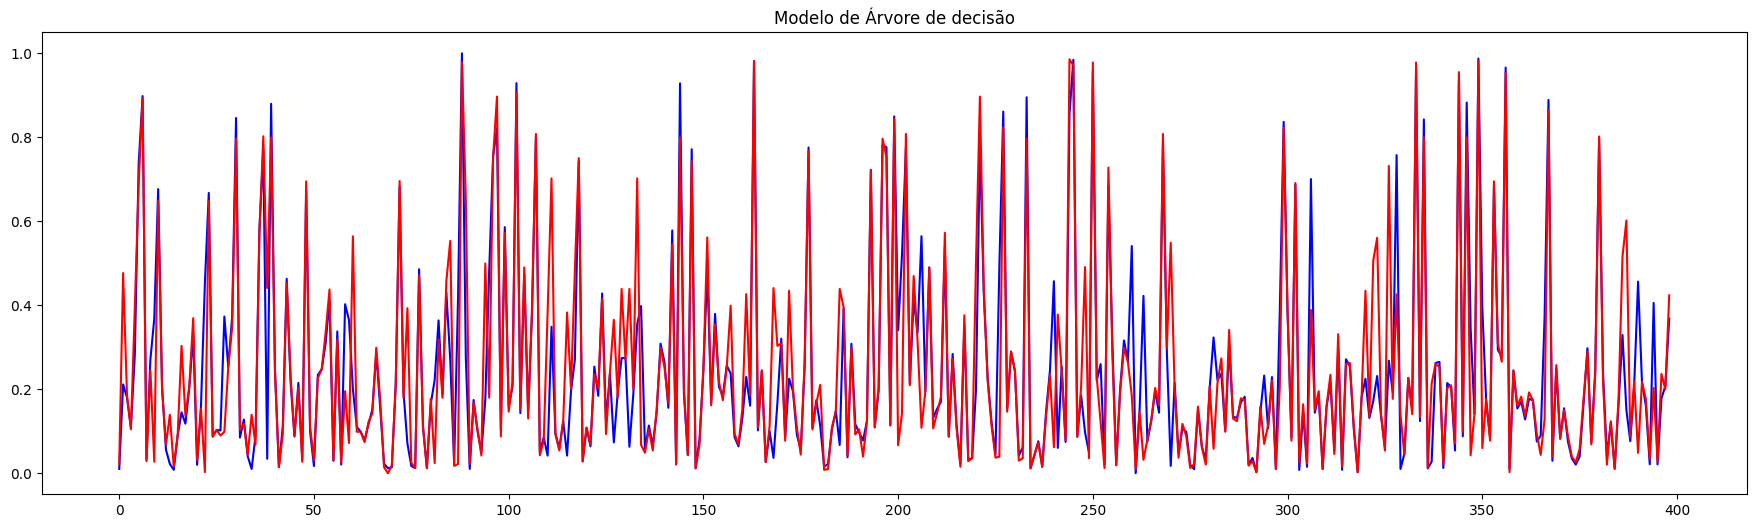

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo de Árvore de decisão');

### RandomForest

In [ ]:
y_pred = RF_reg.predict(x_test)

print(f'R²: {RF_reg.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.9748460161290815
MAE: 0.054880780021507154
MSE: 0.010106198351338233
RMSE: 0.10052958943185948


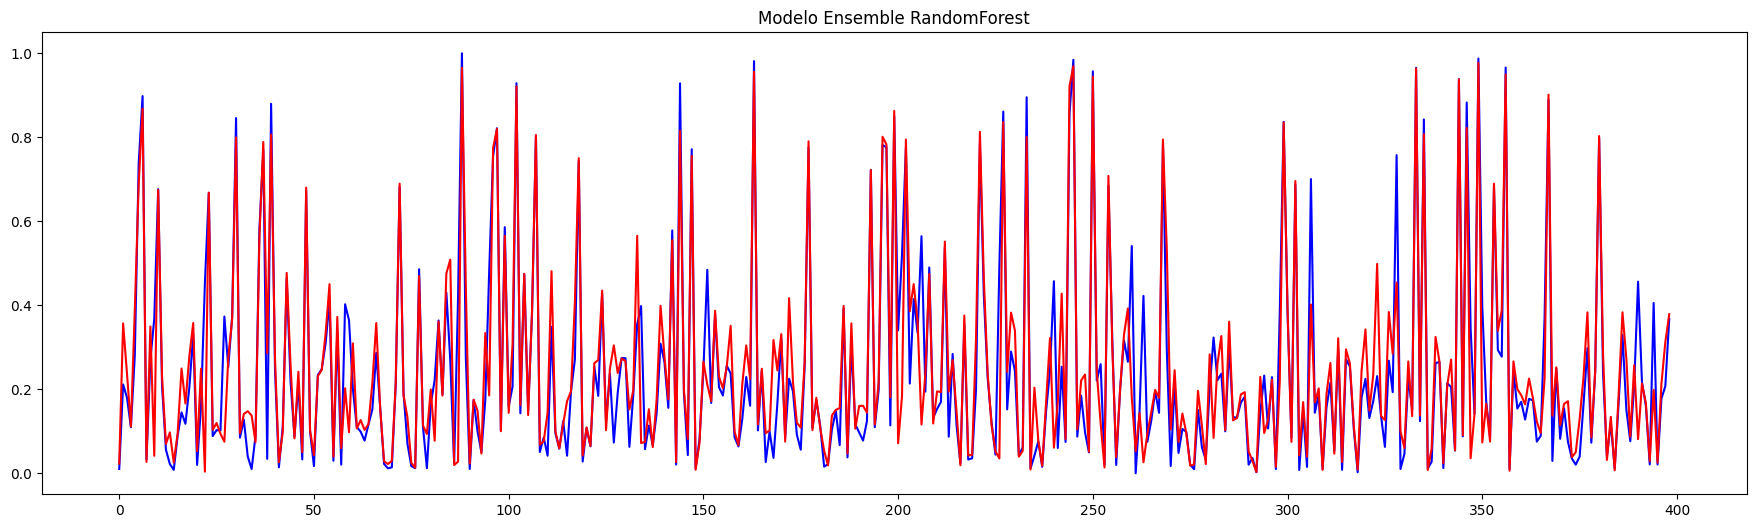

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble RandomForest');

### GradientBoosting

In [ ]:
y_pred = GBR_reg.predict(x_test)

print(f'R²: {GBR_reg.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.9053036692959416
MAE: 0.05119379675364077
MSE: 0.008385347713644768
RMSE: 0.09157154423533966


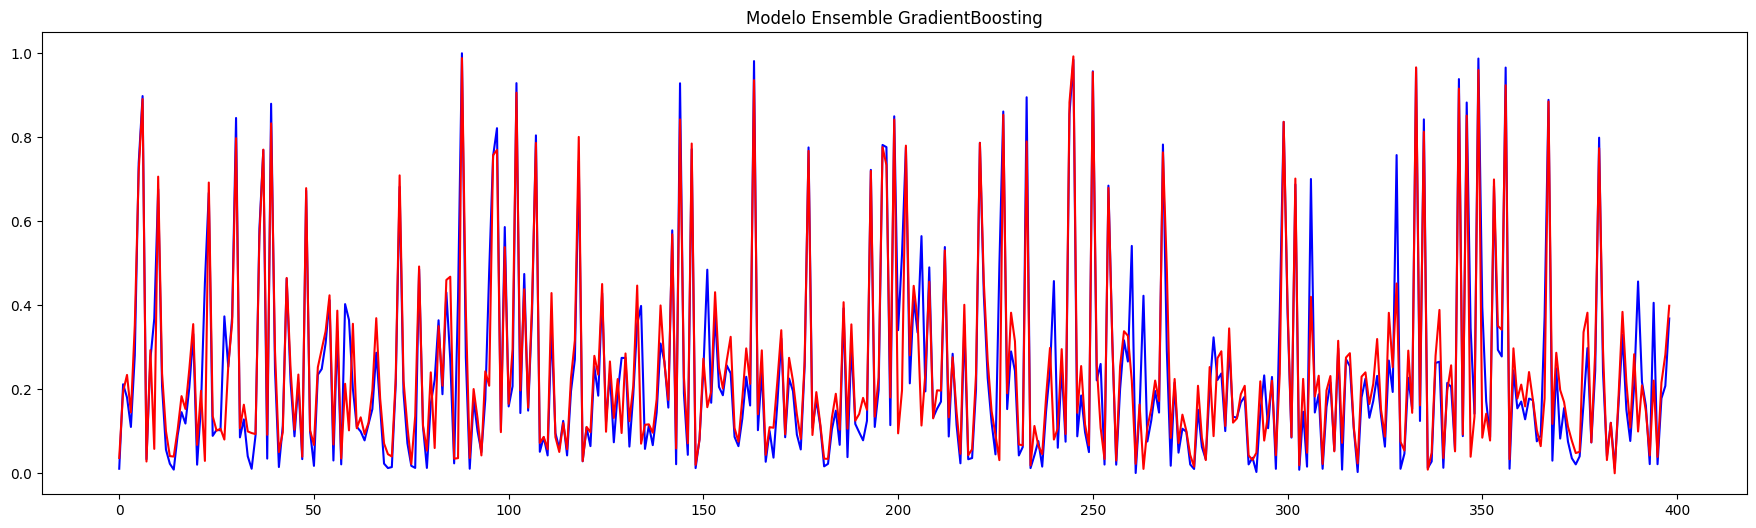

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');

### Adaboost

In [ ]:
y_pred = Ada_reg.predict(x_test)

print(f'R²: {Ada_reg.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.822250966661738
MAE: 0.07998379384394123
MSE: 0.010299061416137147
RMSE: 0.10148429147477528


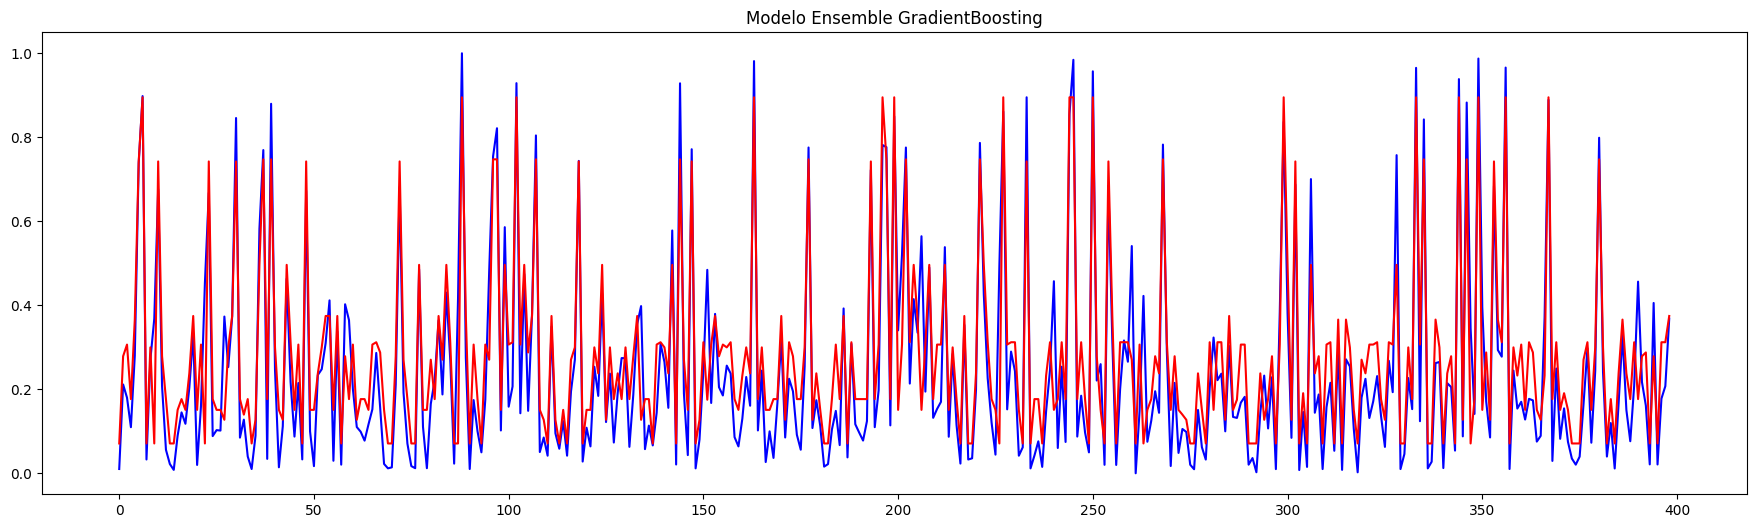

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');

### XGB

In [ ]:
y_pred = XGB.predict(x_test)

print(f'R²: {XGB.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.9963449811337218
MAE: 0.06361561618196782
MSE: 0.01200844709584301
RMSE: 0.10958306025952648


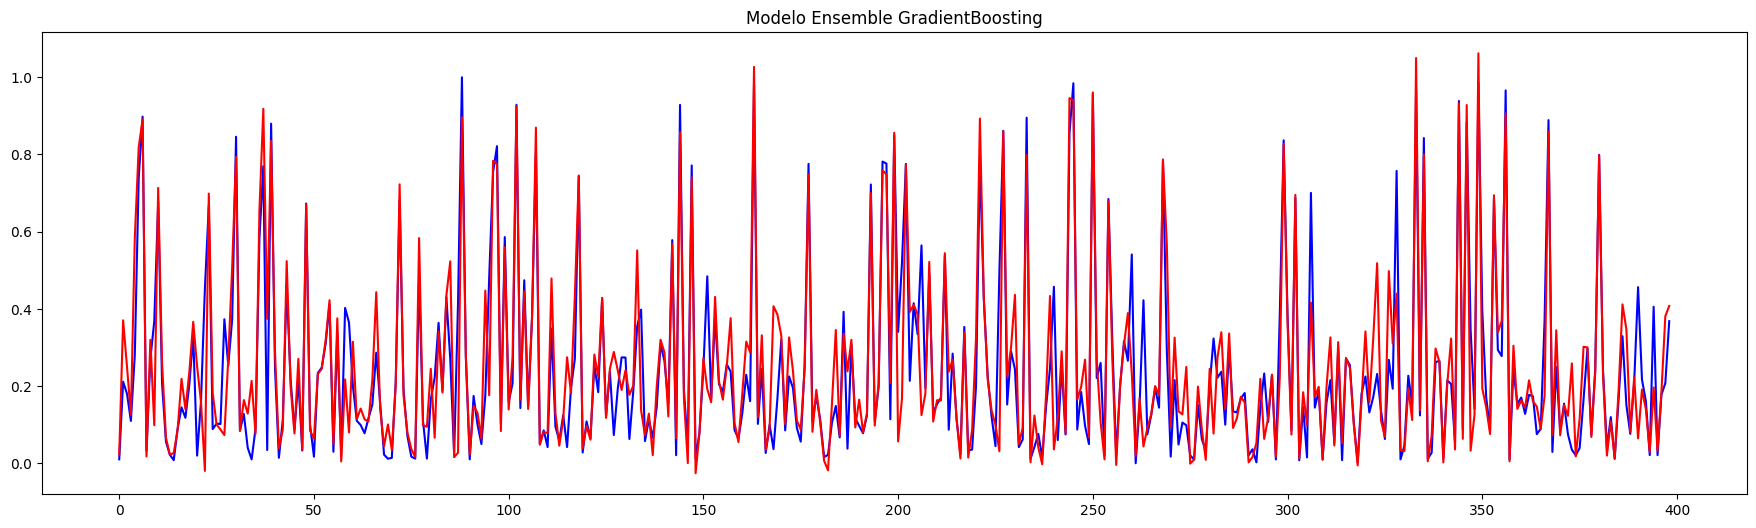

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');

---
**Melhores modelos: DecisionTreeRegressor, RandomForestRegressor e GradientBoostingRegressor**
---

## Otimização de HiperParâmetros

### DecisionTreeRegressor

In [ ]:
params_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [0.2, 'sqrt', 'log2'],
    'random_state': [42]
}

gridsearch = GridSearchCV(DT_reg, param_grid=params_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_features': [0.2, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4], 'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
DT_reg_tunned = DecisionTreeRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=4, random_state=42)
DT_reg_tunned.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=4,
                      random_state=42)

In [ ]:
y_pred = DT_reg_tunned.predict(x_test)

print(f'R²: {DT_reg_tunned.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.8003413001093218
MAE: 0.07615908838118737
MSE: 0.011478408866195921
RMSE: 0.10713733647144641


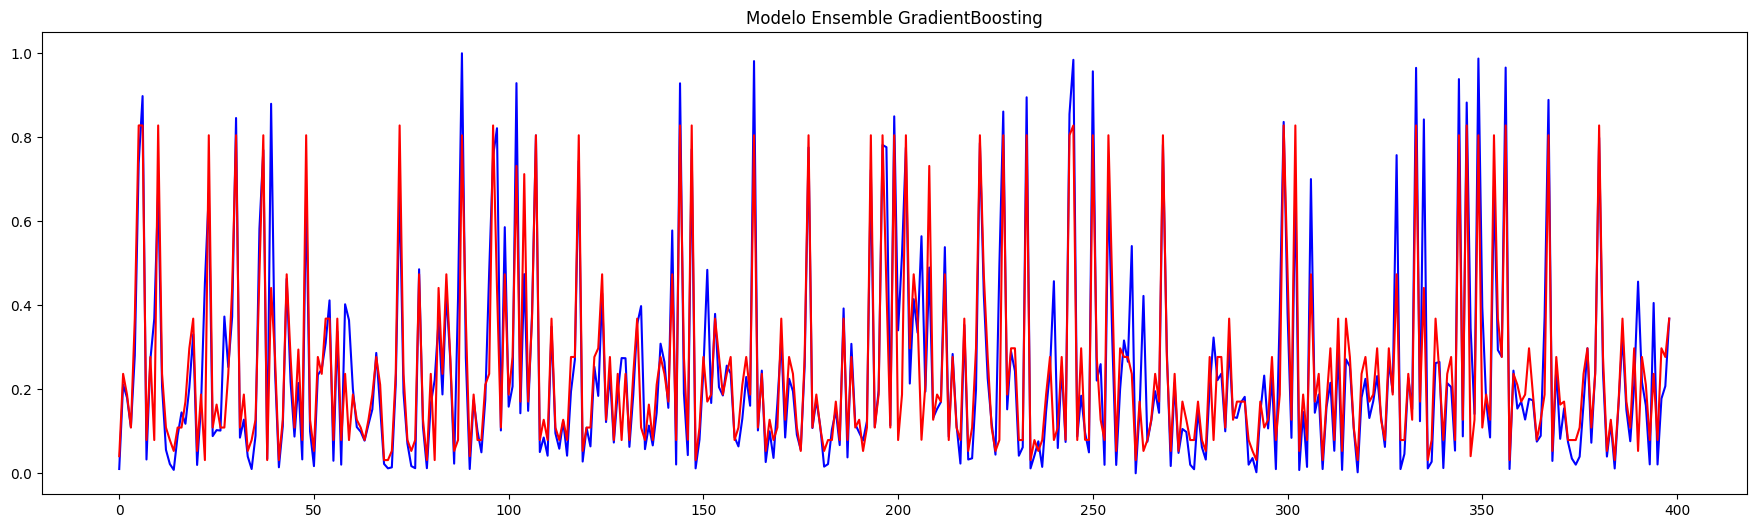

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');


**O modelo foi bem menos performático na otimização de hiper parâmetros do que em seu default**

### RandomForestRegressor

In [ ]:
params_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

gridsearch = GridSearchCV(RF_reg, param_grid=params_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [42]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
RF_reg_tunned = RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=200, random_state=42)
RF_reg_tunned.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=3,
                      n_estimators=200, random_state=42)

In [ ]:
y_pred = RF_reg_tunned.predict(x_test)

print(f'R²: {RF_reg_tunned.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.8592065560038357
MAE: 0.05907502472795842
MSE: 0.008403197672879717
RMSE: 0.09166895697497444


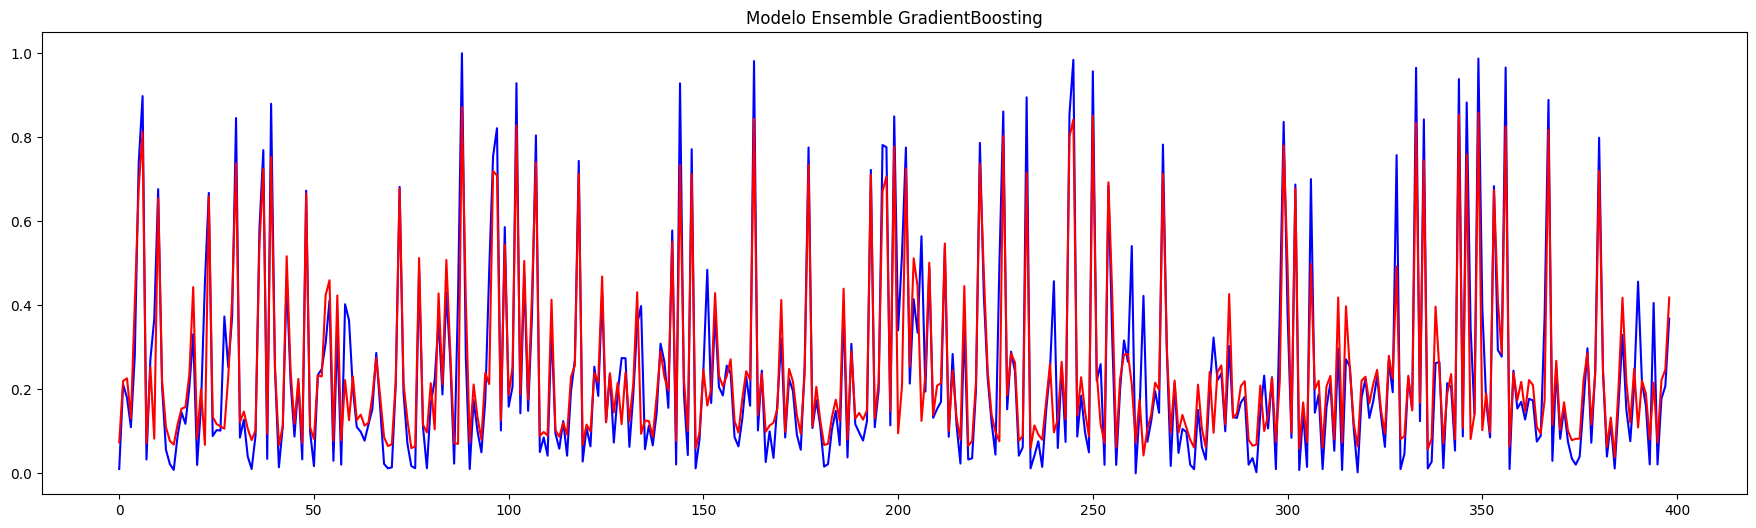

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');

**O modelo não perfomou tão bem quanto seu default**

### GradientBoostingRegressor

In [ ]:
params_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.5, 1.0],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'random_state': [42]
}

gridsearch = GridSearchCV(GBR_reg, param_grid=params_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [42], 'subsample': [0.5, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
GBR_reg_tunned = GradientBoostingRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)
GBR_reg_tunned.fit(x_train, y_train)

GradientBoostingRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)

In [ ]:
y_pred = GBR_reg_tunned.predict(x_test)

print(f'R²: {GBR_reg_tunned.score(x_train, y_train)}')
print(f'MAE: {mtc.mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mtc.mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mtc.mean_squared_error(y_test, y_pred))}')

R²: 0.8829590787952257
MAE: 0.04969686022141607
MSE: 0.007759469533331636
RMSE: 0.08808785122439777


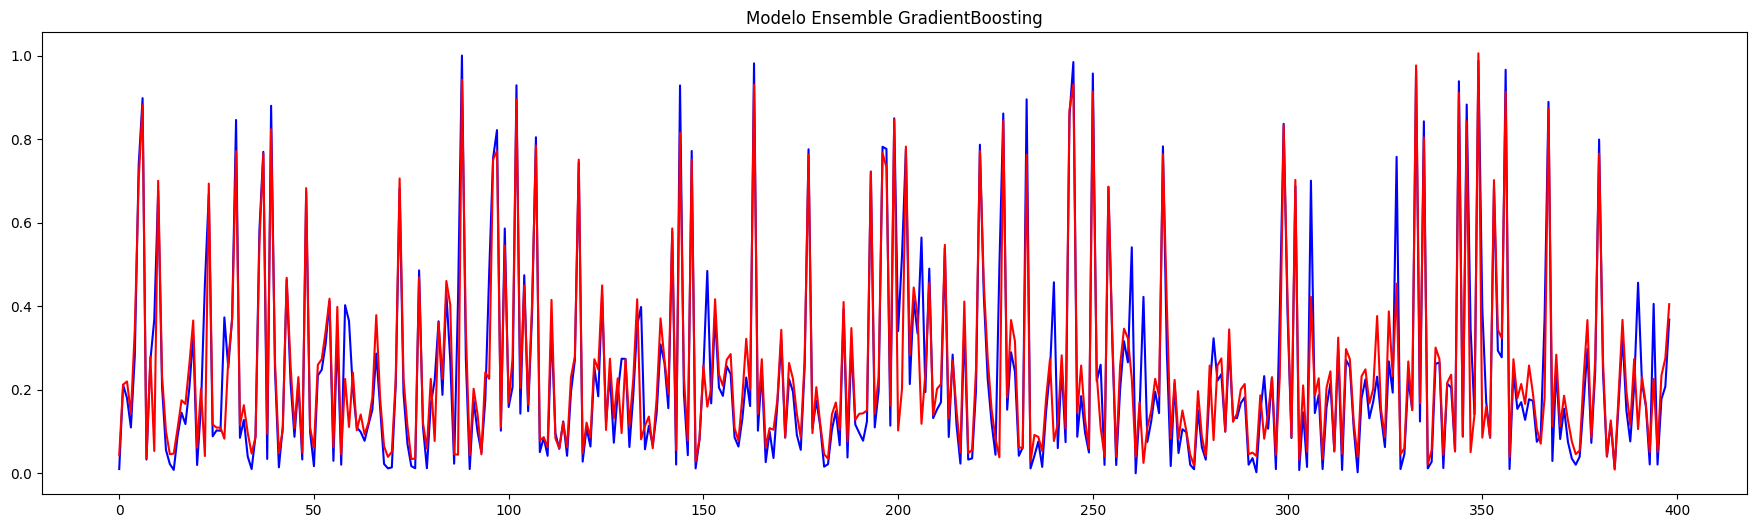

In [ ]:
visual_validation = pd.DataFrame()
visual_validation['real'] = y_test.values
visual_validation['pred'] = y_pred

visual_validation['real'].plot(color='blue', figsize=(22, 6), label='real')
visual_validation['pred'].plot(color='red', figsize=(22, 6), label='predito')
plt.title('Modelo Ensemble GradientBoosting');

**O modelo performou consideravelmente melhor que o default**

# Podium

**Lista de melhores modelos:**

1.   GradientBoostingRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)
2.   RandomForestRegressor(Default)
3. DecisionTreeRegressor(Default)
